## Кластеризация текста на основе датасета с 250 фильмами

___

### 1. Подключение библиотек

In [1]:
import pandas as pd
import string
import re
import nltk
import pymorphy3

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df =pd.read_csv("IMDB_dataset.csv")

In [3]:
df = df.drop(columns="Unnamed: 0")

In [4]:
df.head()

,title,year,description,duration,genre,country
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        248 non-null    object
 1   year         250 non-null    int64 
 2   description  250 non-null    object
 3   duration     250 non-null    object
 4   genre        250 non-null    object
 5   country      250 non-null    object
dtypes: int64(1), object(5)
memory usage: 11.8+ KB


___

### 2. Предварительная обработка данных

1. Перевод всех букв в тексте в нижний регистр
2. Удаление знаков препинания
3. Токенизация по словам
4. Удаление стоп слов
5. Стемминг (приведение слов к нормальной форме)
6. Лемматизация

In [6]:
def remove_punctuation(text): 
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text): 
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text): 
    return re.sub(r'\s+', ' ', text, flags=re.I)

st = '❯\xa0—«»'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [7]:
df['text_new'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(text.lower())))) for text in df['description']]

In [8]:
df.head()

,title,year,description,duration,genre,country,text_new
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...


In [9]:
russian_stopwords = stopwords.words("russian") 
russian_stopwords.extend(['т.д.', 'т', 'д', 'это','который', 'которая', 'с','своём','всем','наш', 'свой', 'ещё', "еще", "также", "так же", "всякий"]) 

In [10]:
def tokenize_text(text):
    t = word_tokenize(text)
    tokens = [token for token in t if not re.search(r'[a-zA-Z]', token)]
    text = " ".join(tokens)
    return text

In [11]:
df['tokenize_texts'] = df['text_new'].apply(tokenize_text)

In [12]:
stemmer = SnowballStemmer("russian")

stem_list = []
for text in (df['tokenize_texts']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = stemmer.stem(word)
            res.append(p)
        text = " ".join(res)
        stem_list.append(text)
    except Exception as e:
        print(e)
        
df['text_stem'] = stem_list

In [13]:
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [14]:
%%time
lemm_texts_list = []
for text in df['tokenize_texts']:
    try:
        tokens = word_tokenize(text)
        res = []
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
        lemm_texts_list.append("")

df['text_lemm'] = lemm_texts_list

CPU times: total: 688 ms
Wall time: 691 ms


In [15]:
df.head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...,банкир осужденный за уксорицид образует дружбу...,банкир осужден за уксорицид образ дружб за чет...,банкир осудить за уксорицид образовать дружба ...
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...,старение патриарха организованной криминальной...,старен патриарх организова криминальн династ п...,старение патриарх организовать криминальный ди...
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...,когда угроза известная как джокер наносит ущер...,когд угроз известн как джокер нанос ущерб и ха...,когда угроза известный как джокер наносить уще...
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...,ранняя жизнь и карьера вито корлеоне в х годах...,ран жизн и карьер вит корлеон в х год изобража...,ранний жизнь и карьера вить корлеон в х год из...
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...,присяжные в суде по делу об убийстве в нью йор...,присяжн в суд по дел об убийств в нью йорк раз...,присяжный в суд по дело о убийство в нью йорк ...


In [16]:
df['text_lemm'] = df['text_lemm'].apply(lambda x: ' '.join([word for word in x.split() if word not in russian_stopwords]))

___

# Облако слов

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

<Axes: >

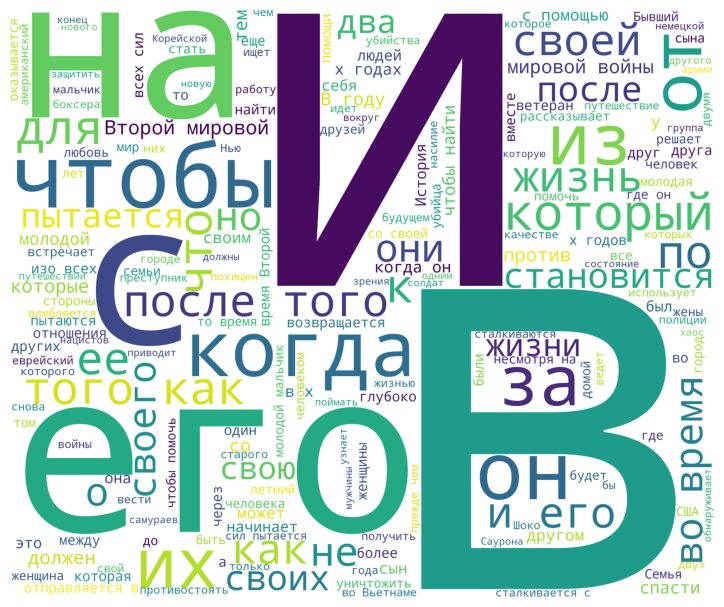

In [19]:
corpus = get_corpus(df['description'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

<Axes: >

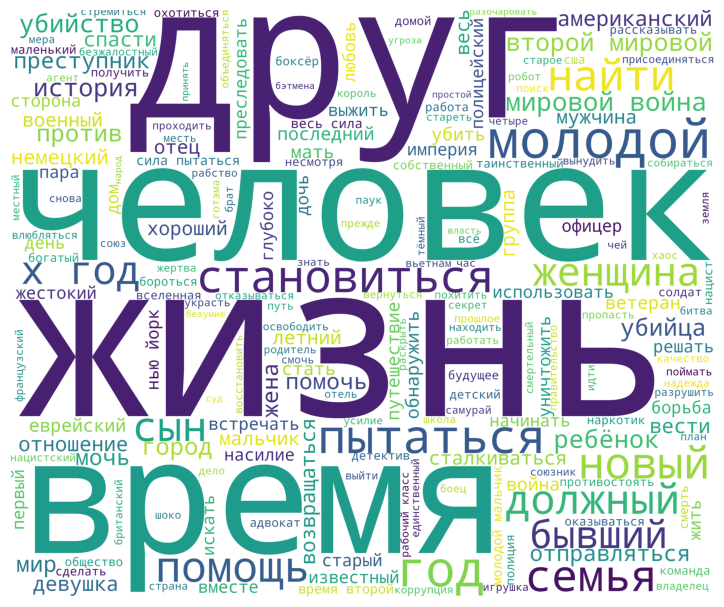

In [20]:
corpus = get_corpus(df['text_lemm'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

___

## Векторизация текстовых данных

#### **Bag of words**

Смотрим наличие слов в текстовых данных

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
df['text_lemm'][0]

'банкир осудить уксорицид образовать дружба четверть век закалённый осудить сохранять невиновность пытаться оставаться надежда простой сострадание'

In [23]:
vectorizer = CountVectorizer()
vectorizer.fit(df['text_lemm'])

CountVectorizer()

In [24]:
print(vectorizer.vocabulary_)

{'банкир': 68, 'осудить': 1159, 'уксорицид': 1981, 'образовать': 1084, 'дружба': 469, 'четверть': 2097, 'век': 172, 'закалённый': 521, 'сохранять': 1776, 'невиновность': 1006, 'пытаться': 1517, 'оставаться': 1149, 'надежда': 946, 'простой': 1488, 'сострадание': 1773, 'старение': 1810, 'патриарх': 1220, 'организовать': 1135, 'криминальный': 761, 'династия': 432, 'передавать': 1230, 'контроль': 736, 'тайна': 1876, 'империя': 611, 'неохотный': 1034, 'сын': 1871, 'угроза': 1960, 'известный': 586, 'джокер': 423, 'наносить': 964, 'ущерб': 2011, 'хаос': 2048, 'народ': 973, 'готэма': 356, 'бэтмена': 156, 'джеймс': 414, 'гордон': 349, 'харви': 2050, 'дента': 393, 'должный': 450, 'работать': 1523, 'вместе': 208, 'положить': 1324, 'конец': 727, 'безумие': 83, 'ранний': 1551, 'жизнь': 500, 'карьера': 676, 'вить': 198, 'корлеон': 744, 'год': 341, 'изображаться': 598, 'время': 263, 'майкл': 839, 'расширять': 1566, 'подтягивать': 1301, 'власть': 203, 'отношение': 1177, 'синдикат': 1692, 'семейный': 1

In [25]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)
count_matrix = vectorizer.fit_transform(df['text_lemm'])

In [26]:
count_matrix.shape

(250, 746)

In [27]:
vectorizer.get_feature_names_out()[45000:46000]

array([], dtype=object)

In [28]:
print(count_matrix)

  (0, 377)	1
  (0, 54)	1
  (0, 536)	1
  (0, 332)	1
  (0, 518)	1
  (0, 624)	1
  (1, 426)	1
  (1, 225)	1
  (1, 664)	1
  (2, 689)	1
  (2, 219)	1
  (2, 716)	1
  (2, 341)	1
  (2, 135)	1
  (2, 50)	1
  (2, 158)	1
  (2, 164)	1
  (2, 541)	1
  (2, 76)	1
  (2, 452)	1
  (2, 261)	1
  (2, 22)	1
  (2, 453)	1
  (3, 664)	1
  (3, 183)	1
  :	:
  (247, 345)	1
  (247, 537)	1
  (247, 28)	1
  (247, 609)	1
  (248, 179)	2
  (248, 367)	1
  (248, 12)	1
  (248, 180)	1
  (248, 504)	1
  (248, 217)	1
  (248, 425)	1
  (248, 188)	1
  (248, 569)	1
  (249, 536)	1
  (249, 724)	1
  (249, 648)	1
  (249, 629)	1
  (249, 682)	1
  (249, 538)	1
  (249, 590)	1
  (249, 487)	1
  (249, 683)	1
  (249, 304)	1
  (249, 613)	1
  (249, 197)	1


### **TF-IDF**

Вычисляем «относительную частоту» появления слова в одном документе по сравнению с его частотой во всех разом

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [98]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=4,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))

In [100]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_lemm'])

CPU times: total: 15.6 ms
Wall time: 18.2 ms


In [101]:
tfidf_matrix.shape

(250, 4)

In [102]:
tfidf_vectorizer.get_feature_names_out()[:100]

array(['время', 'год', 'жизнь', 'молодой'], dtype=object)

In [96]:
print(tfidf_matrix)

  (0, 5)	1.0
  (3, 3)	0.5604229470117282
  (3, 1)	0.5766821101920077
  (3, 0)	0.5944441641123098
  (5, 6)	1.0
  (6, 1)	0.6963022656132148
  (6, 0)	0.7177486711251398
  (7, 3)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (14, 0)	0.6690240685660062
  (14, 2)	0.7432407387108084
  (15, 3)	1.0
  (16, 3)	1.0
  (17, 1)	1.0
  (18, 6)	1.0
  (20, 3)	1.0
  (22, 4)	1.0
  (24, 5)	1.0
  (28, 5)	1.0
  (29, 1)	0.5444183379888997
  (29, 0)	0.5611866540223908
  (29, 2)	0.6234406247659499
  (30, 0)	0.6829469438562521
  (30, 6)	0.7304679814183543
  :	:
  (227, 4)	0.7312229893844662
  (228, 5)	0.7407074559985303
  (228, 1)	0.6718277045702901
  (229, 2)	0.7397187401763616
  (229, 4)	0.6729161800936998
  (230, 5)	0.7501791355065274
  (230, 3)	0.6612346517316521
  (231, 1)	0.6925086458220884
  (231, 4)	0.721409575388113
  (232, 2)	1.0
  (234, 2)	1.0
  (236, 6)	0.7268620147887478
  (236, 4)	0.6867835259069939
  (237, 1)	1.0
  (238, 3)	0.6969248083175988
  (238, 1)	0.7171442055482832
  (239, 4)	1.0
  (240, 0)	1.0
  (241, 

___

## Кластеризация данных

### **K-means**

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

  File "c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


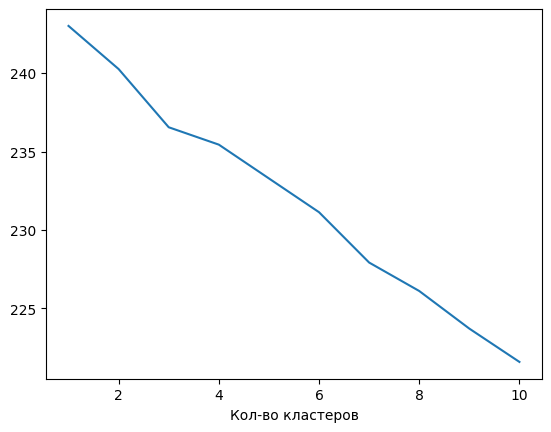

In [36]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel('Кол-во кластеров')
plt.show()

In [37]:
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10, random_state = 42)

In [38]:
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [39]:
pred=kmeans.fit_predict(tfidf_matrix)

cluster
1    102
0     42
4     28
6     25
3     24
5     17
2     12
Name: count, dtype: int64


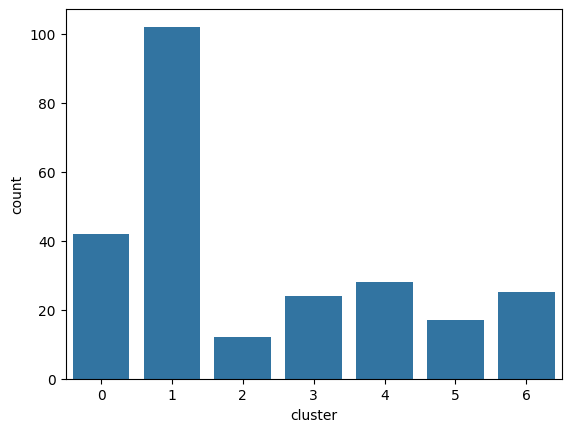

In [40]:
# Смотрим распределение по кластерам
df['cluster'] = pred
print(df['cluster'].value_counts())
sns.countplot(x='cluster', data=df)
plt.show()

In [41]:
df.head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...,банкир осужденный за уксорицид образует дружбу...,банкир осужден за уксорицид образ дружб за чет...,банкир осудить уксорицид образовать дружба чет...,6
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...,старение патриарха организованной криминальной...,старен патриарх организова криминальн династ п...,старение патриарх организовать криминальный ди...,5
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...,когда угроза известная как джокер наносит ущер...,когд угроз известн как джокер нанос ущерб и ха...,угроза известный джокер наносить ущерб хаос на...,1
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...,ранняя жизнь и карьера вито корлеоне в х годах...,ран жизн и карьер вит корлеон в х год изобража...,ранний жизнь карьера вить корлеон х год изобра...,5
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...,присяжные в суде по делу об убийстве в нью йор...,присяжн в суд по дел об убийств в нью йорк раз...,присяжный суд дело убийство нью йорк разочаров...,1


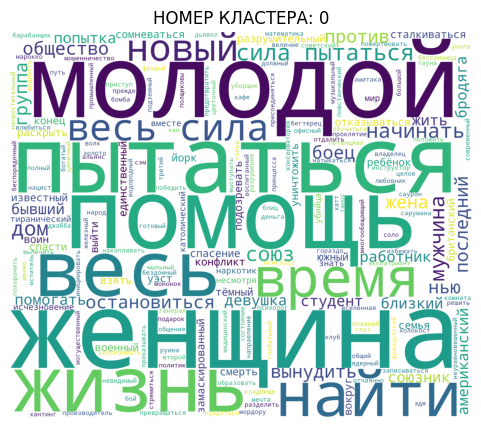

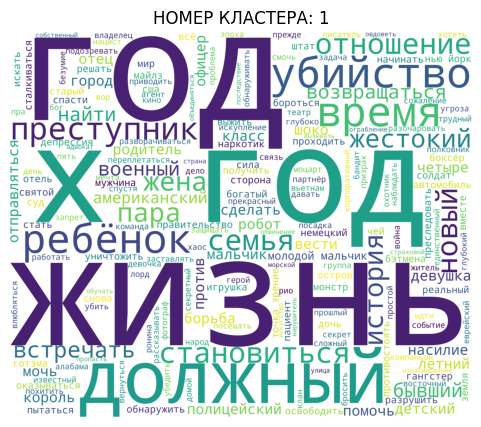

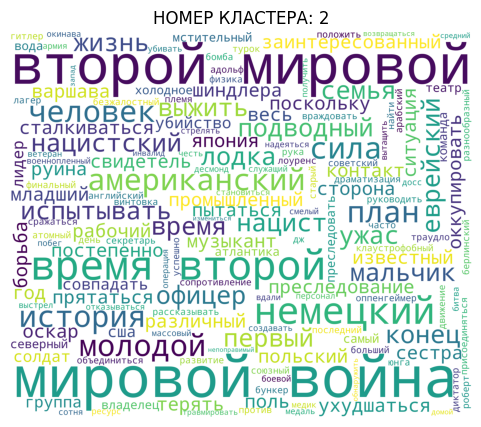

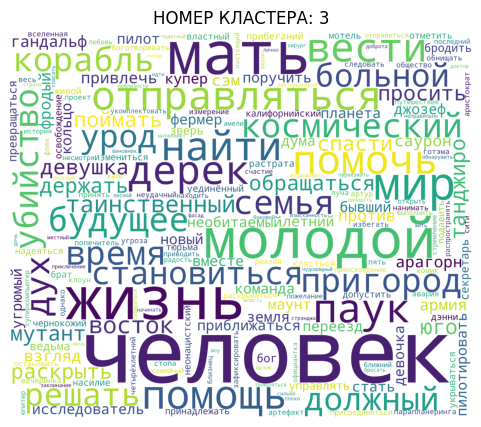

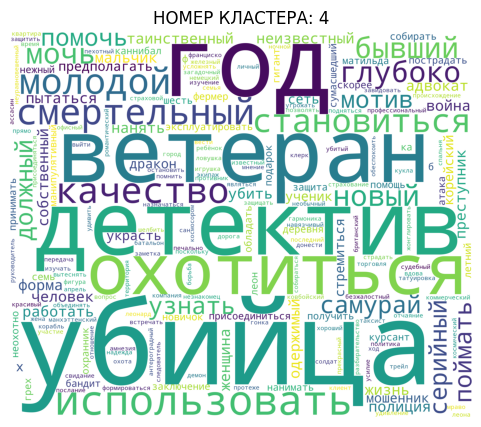

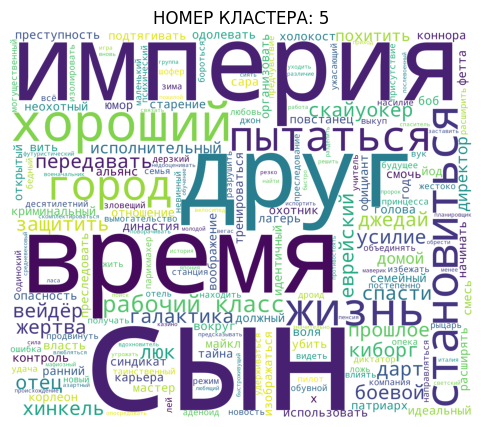

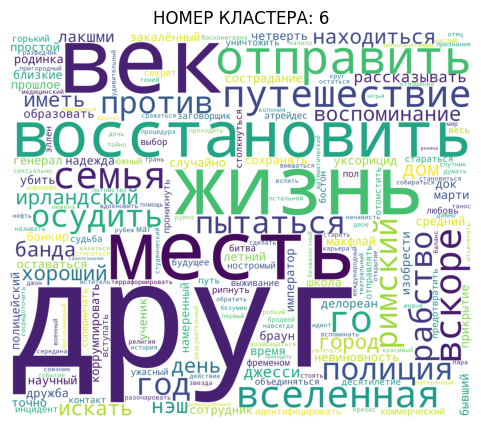

In [42]:
for i in sorted(df['cluster'].unique()):
    corpus = get_corpus(df[df['cluster'] == i].text_lemm.values)
    procWordCloud = get_wordCloud(corpus)
    
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(procWordCloud)
    plt.axis('off')
    plt.title(f'НОМЕР КЛАСТЕРА: {i}')
    plt.subplot(1, 2, 1)

In [43]:
df_cluster = pd.DataFrame()

In [44]:
df_cluster['name'] = ['Борьба', 'Новая жизнь', 'Война', 'Эпичные испытания', 'Охота на убийц', 'Власть', 'Борьба и противостоянние']

In [45]:
df_cluster

,name
0,Борьба
1,Новая жизнь
2,Война
3,Эпичные испытания
4,Охота на убийц
5,Власть
6,Борьба и противостоянние


___

## Классификация

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [47]:
df.head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...,банкир осужденный за уксорицид образует дружбу...,банкир осужден за уксорицид образ дружб за чет...,банкир осудить уксорицид образовать дружба чет...,6
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...,старение патриарха организованной криминальной...,старен патриарх организова криминальн династ п...,старение патриарх организовать криминальный ди...,5
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...,когда угроза известная как джокер наносит ущер...,когд угроз известн как джокер нанос ущерб и ха...,угроза известный джокер наносить ущерб хаос на...,1
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...,ранняя жизнь и карьера вито корлеоне в х годах...,ран жизн и карьер вит корлеон в х год изобража...,ранний жизнь карьера вить корлеон х год изобра...,5
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...,присяжные в суде по делу об убийстве в нью йор...,присяжн в суд по дел об убийств в нью йорк раз...,присяжный суд дело убийство нью йорк разочаров...,1


In [48]:
X = df.drop(columns=['title', 'genre', 'description', 'text_new', 'tokenize_texts', 'text_stem', 'text_lemm'])  # Признаки
y = df['cluster']  # Целевая переменная (метки кластеров)

In [49]:
X.head()

,year,duration,country,cluster
0,1994,2 hours 22 minutes,United States,6
1,1972,2 hours 55 minutes,United States,5
2,2008,2 hours 32 minutes,United States,1
3,1974,3 hours 22 minutes,United States,5
4,1957,1 hour 36 minutes,United States,1


In [50]:
# Список уникальных стран
unique_countries = [
    'United States', 'New Zealand', 'Italy', 'Germany', 'Japan',
    'Brazil', 'France', 'South Korea', 'United Kingdom', 'Canada',
    'India', 'West Germany', 'Lebanon', 'Soviet Union', 'Denmark',
    'Iran', 'Mexico', 'Spain', 'Argentina', 'Australia', 'Ireland',
    'Sweden', 'Turkey'
]

# Создаем словарь
countries = {country: idx for idx, country in enumerate(unique_countries)}

In [51]:
X['country_code'] = X['country'].apply(lambda x: countries[x])

In [52]:
X = X.drop('country', axis=1)

In [53]:
X.head(250)

,year,duration,cluster,country_code
0,1994,2 hours 22 minutes,6,0
1,1972,2 hours 55 minutes,5,0
2,2008,2 hours 32 minutes,1,0
3,1974,3 hours 22 minutes,5,0
4,1957,1 hour 36 minutes,1,0
...,...,...,...,...
245,2016,2 hours 10 minutes,1,4
246,2011,2 hours 26 minutes,1,0
247,2000,2 hours 34 minutes,0,16
248,1940,2 hours 10 minutes,0,0


In [54]:
# Преобразуем длительность в минуты
def convert_duration(duration_str):
    if pd.isna(duration_str):
        return 0
    parts = duration_str.split()
    hours = 0
    minutes = 0
    for i, part in enumerate(parts):
        if part == 'hours':
            hours = float(parts[i-1])
        elif part == 'minutes':
            minutes = float(parts[i-1])
    return hours * 60 + minutes

X['duration'] = X['duration'].apply(convert_duration)

In [55]:
X.head()

,year,duration,cluster,country_code
0,1994,142.0,6,0
1,1972,175.0,5,0
2,2008,152.0,1,0
3,1974,202.0,5,0
4,1957,36.0,1,0


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [57]:
# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [58]:
# Функция для обучения и оценки модели
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Итоги
    print(classification_report(y_test, y_pred))
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

In [ ]:
# Модели для тестирования
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, max_features=7)
}

In [60]:
# Оценка моделей
results = {}
for name, model in models.items():
    print(f"{name}")
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.84      1.00      0.91        32
           2       0.00      0.00      0.00         4
           3       0.80      0.36      0.50        11
           4       0.62      0.80      0.70        10
           5       0.50      0.20      0.29         5
           6       0.80      1.00      0.89         8

    accuracy                           0.80        83
   macro avg       0.65      0.62      0.61        83
weighted avg       0.77      0.80      0.76        83

Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00 

In [61]:
# Создание таблицы для сравнения моделей
results_df = pd.DataFrame(results).T
print("Сравнение моделей классификации:")
print(results_df)

Сравнение моделей классификации:
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.795181   0.768689  0.795181  0.762089
Decision Tree        1.000000   1.000000  1.000000  1.000000
Random Forest        0.951807   0.975904  0.951807  0.954485


##### Лучше всего себя показала модель Decision Tree. Но т.к. это может быть связано с переобучением, лучше использовать **Random Forest**

___

## Тематическое моделирование

In [62]:
import gensim 
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [63]:
def tokenize2(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return tokens

In [64]:
df['lemm_tokenize'] = [tokenize2(text) for text in df['text_lemm']]

In [65]:
df.head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster,lemm_tokenize
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...,банкир осужденный за уксорицид образует дружбу...,банкир осужден за уксорицид образ дружб за чет...,банкир осудить уксорицид образовать дружба чет...,6,"[банкир, осудить, уксорицид, образовать, дружб..."
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...,старение патриарха организованной криминальной...,старен патриарх организова криминальн династ п...,старение патриарх организовать криминальный ди...,5,"[старение, патриарх, организовать, криминальны..."
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...,когда угроза известная как джокер наносит ущер...,когд угроз известн как джокер нанос ущерб и ха...,угроза известный джокер наносить ущерб хаос на...,1,"[угроза, известный, джокер, наносить, ущерб, х..."
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...,ранняя жизнь и карьера вито корлеоне в х годах...,ран жизн и карьер вит корлеон в х год изобража...,ранний жизнь карьера вить корлеон х год изобра...,5,"[ранний, жизнь, карьера, вить, корлеон, х, год..."
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...,присяжные в суде по делу об убийстве в нью йор...,присяжн в суд по дел об убийств в нью йорк раз...,присяжный суд дело убийство нью йорк разочаров...,1,"[присяжный, суд, дело, убийство, нью, йорк, ра..."


In [66]:
# Функция для алгоритма тематического моделирования, который выявляет скрытые темы
def lda5_model(df):
    gensim_dictionary = gensim.corpora.Dictionary(df['lemm_tokenize']) # преобразовываем токены в словарь

    corpus = [gensim_dictionary.doc2bow(text) for text in df['lemm_tokenize']] # получаем кортеж "мешка слов"

    lda_5 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=5, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

    for tpl in lda_5.print_topics():
        print(tpl, end='\n\n')
    print()
    
    vis_5 = gensimvis.prepare(lda_5, corpus, gensim_dictionary)
    pyLDAvis.enable_notebook()
    display(pyLDAvis.display(vis_5))

In [67]:
# Функция для алгоритма снижения размерности, который выявляет скрытые темы
from sklearn.decomposition import TruncatedSVD


def lsa5_model(df):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_lemm'])
    
    lsa_model = TruncatedSVD(n_components=5, random_state=0)
    lsa_model.fit(tfidf_matrix)
    
    for i, topic in enumerate(lsa_model.components_):
        print(f"Тема номер {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

In [68]:
print('LDA модель\n' + '_' * 100)
for cluster in sorted(df['cluster'].unique()):
    new_df = df[df['cluster'] == cluster]
    print(f'КЛАСТЕР: {cluster}\n')
    lda5_model(new_df)
    print('_' * 100)

LDA модель
____________________________________________________________________________________________________
КЛАСТЕР: 0

(0, '0.023*"помощь" + 0.012*"против" + 0.007*"дом" + 0.007*"новый" + 0.007*"близкий" + 0.007*"время" + 0.007*"несмотря" + 0.007*"союзник" + 0.007*"сталкиваться" + 0.007*"лидер"')

(1, '0.017*"сила" + 0.011*"пытаться" + 0.011*"женщина" + 0.011*"молодой" + 0.007*"время" + 0.007*"вынудить" + 0.007*"уничтожить" + 0.007*"знать" + 0.007*"вместе" + 0.007*"последний"')

(2, '0.026*"молодой" + 0.018*"женщина" + 0.013*"весь" + 0.009*"помощь" + 0.009*"остановиться" + 0.009*"попытка" + 0.009*"общество" + 0.009*"пытаться" + 0.005*"тиранический" + 0.005*"исчезновение"')

(3, '0.014*"жизнь" + 0.010*"помощь" + 0.010*"найти" + 0.010*"молодой" + 0.010*"союз" + 0.010*"работник" + 0.010*"наркотик" + 0.010*"пытаться" + 0.005*"конфликт" + 0.005*"вокруг"')

(4, '0.021*"пытаться" + 0.018*"весь" + 0.015*"женщина" + 0.011*"жена" + 0.011*"нью" + 0.011*"начинать" + 0.008*"сила" + 0.008*"мужч

____________________________________________________________________________________________________
КЛАСТЕР: 1

(0, '0.011*"год" + 0.009*"преступник" + 0.009*"х" + 0.007*"вести" + 0.004*"против" + 0.004*"король" + 0.004*"молодой" + 0.004*"мальчик" + 0.004*"сделать" + 0.004*"игрушка"')

(1, '0.011*"жизнь" + 0.006*"насилие" + 0.006*"жена" + 0.006*"четыре" + 0.006*"время" + 0.006*"чей" + 0.004*"бороться" + 0.004*"разрушить" + 0.004*"ребёнок" + 0.004*"убийство"')

(2, '0.009*"жизнь" + 0.009*"летний" + 0.007*"год" + 0.005*"ребёнок" + 0.005*"родитель" + 0.005*"джек" + 0.005*"похитить" + 0.005*"отношение" + 0.005*"отец" + 0.005*"день"')

(3, '0.017*"год" + 0.006*"новый" + 0.006*"встречать" + 0.006*"мальчик" + 0.006*"жизнь" + 0.006*"убийство" + 0.005*"должный" + 0.005*"военный" + 0.005*"пара" + 0.005*"майлз"')

(4, '0.011*"год" + 0.009*"становиться" + 0.009*"семья" + 0.009*"шоко" + 0.007*"ребёнок" + 0.007*"должный" + 0.007*"возвращаться" + 0.007*"класс" + 0.007*"монстр" + 0.006*"американский"

____________________________________________________________________________________________________
КЛАСТЕР: 2

(0, '0.037*"мировой" + 0.037*"второй" + 0.037*"война" + 0.025*"лодка" + 0.025*"подводный" + 0.014*"время" + 0.014*"нацистский" + 0.014*"жизнь" + 0.014*"испытывать" + 0.014*"ужас"')

(1, '0.045*"война" + 0.045*"время" + 0.045*"мировой" + 0.031*"второй" + 0.031*"план" + 0.017*"первый" + 0.017*"лоуренс" + 0.017*"руководить" + 0.017*"племя" + 0.017*"часто"')

(2, '0.040*"второй" + 0.040*"мировой" + 0.040*"война" + 0.021*"молодой" + 0.021*"история" + 0.021*"сила" + 0.021*"время" + 0.021*"мальчик" + 0.021*"американский" + 0.021*"человек"')

(3, '0.033*"второй" + 0.033*"нацист" + 0.033*"мировой" + 0.033*"война" + 0.018*"сила" + 0.018*"семья" + 0.018*"еврейский" + 0.018*"сторона" + 0.018*"шиндлера" + 0.018*"оккупировать"')

(4, '0.040*"немецкий" + 0.022*"время" + 0.022*"офицер" + 0.022*"человек" + 0.022*"операция" + 0.022*"ресурс" + 0.022*"надеяться" + 0.022*"смелый" + 0.022*"создав

____________________________________________________________________________________________________
КЛАСТЕР: 3

(0, '0.018*"становиться" + 0.018*"молодой" + 0.018*"нанимать" + 0.018*"авария" + 0.018*"попечитель" + 0.018*"четырёхлетний" + 0.018*"парапланеринга" + 0.018*"аристократ" + 0.018*"проект" + 0.018*"человек"')

(1, '0.041*"человек" + 0.025*"жизнь" + 0.025*"дерек" + 0.017*"молодой" + 0.009*"пригород" + 0.009*"бунт" + 0.009*"день" + 0.009*"французский" + 0.009*"следующий" + 0.009*"час"')

(2, '0.036*"мать" + 0.010*"больной" + 0.010*"дух" + 0.010*"семья" + 0.010*"спасти" + 0.010*"девушка" + 0.010*"мир" + 0.010*"держать" + 0.010*"восток" + 0.010*"раскрыть"')

(3, '0.040*"человек" + 0.021*"паук" + 0.014*"жизнь" + 0.008*"таинственный" + 0.008*"найти" + 0.008*"помощь" + 0.008*"решать" + 0.008*"просить" + 0.008*"должный" + 0.008*"мир"')

(4, '0.037*"человек" + 0.017*"помочь" + 0.017*"молодой" + 0.011*"жизнь" + 0.011*"юго" + 0.011*"мутант" + 0.011*"танджиро" + 0.011*"будущее" + 0.011*"п

____________________________________________________________________________________________________
КЛАСТЕР: 4

(0, '0.031*"убийца" + 0.016*"детектив" + 0.016*"использовать" + 0.011*"бывший" + 0.011*"сеть" + 0.011*"мотив" + 0.011*"серийный" + 0.011*"собственный" + 0.006*"обман" + 0.006*"оказываться"')

(1, '0.016*"охотиться" + 0.016*"молодой" + 0.016*"становиться" + 0.016*"предполагать" + 0.016*"дракон" + 0.009*"убийца" + 0.009*"год" + 0.009*"помочь" + 0.009*"леона" + 0.009*"изучать"')

(2, '0.014*"мочь" + 0.014*"женщина" + 0.014*"детектив" + 0.014*"полиция" + 0.014*"убить" + 0.014*"использовать" + 0.014*"год" + 0.014*"новый" + 0.014*"ученик" + 0.007*"молодой"')

(3, '0.014*"качество" + 0.014*"работать" + 0.008*"защитить" + 0.008*"известный" + 0.008*"вдова" + 0.008*"загадочный" + 0.008*"безжалостный" + 0.008*"незнакомец" + 0.008*"железный" + 0.008*"объединять"')

(4, '0.022*"ветеран" + 0.015*"смертельный" + 0.015*"год" + 0.015*"война" + 0.015*"самурай" + 0.008*"пытаться" + 0.008*"адво

____________________________________________________________________________________________________
КЛАСТЕР: 5

(0, '0.046*"сын" + 0.024*"хороший" + 0.024*"становиться" + 0.024*"жизнь" + 0.013*"защитить" + 0.013*"еврейский" + 0.013*"жертва" + 0.013*"открытый" + 0.013*"холокост" + 0.013*"смесь"')

(1, '0.028*"сын" + 0.022*"империя" + 0.015*"киборг" + 0.015*"усилие" + 0.015*"боевой" + 0.015*"спасти" + 0.008*"мафиозный" + 0.008*"вегас" + 0.008*"быстро" + 0.008*"скомплектироваться"')

(2, '0.031*"сын" + 0.024*"город" + 0.024*"время" + 0.016*"рабочий" + 0.016*"класс" + 0.016*"пытаться" + 0.016*"хинкель" + 0.009*"империя" + 0.009*"предсказывать" + 0.009*"футуристический"')

(3, '0.025*"время" + 0.014*"империя" + 0.014*"дарт" + 0.014*"галактика" + 0.014*"скайуокер" + 0.014*"люк" + 0.014*"вейдёр" + 0.014*"джедай" + 0.014*"прошлое" + 0.014*"отец"')

(4, '0.027*"друг" + 0.027*"сын" + 0.015*"империя" + 0.015*"передавать" + 0.015*"похитить" + 0.015*"директор" + 0.015*"исполнительный" + 0.015*"ста

____________________________________________________________________________________________________
КЛАСТЕР: 6

(0, '0.028*"друг" + 0.021*"век" + 0.021*"го" + 0.015*"отправить" + 0.015*"месть" + 0.015*"рабство" + 0.015*"римский" + 0.008*"искать" + 0.008*"восстановить" + 0.008*"воспоминание"')

(1, '0.022*"вселенная" + 0.015*"осудить" + 0.015*"находиться" + 0.008*"дом" + 0.008*"мочь" + 0.008*"волшебный" + 0.008*"ферма" + 0.008*"вернуть" + 0.008*"увидеть" + 0.008*"оз"')

(2, '0.017*"восстановить" + 0.017*"друг" + 0.017*"лакшми" + 0.009*"жизнь" + 0.009*"королева" + 0.009*"потомство" + 0.009*"эллен" + 0.009*"терраформировать" + 0.009*"рипнуть" + 0.009*"контакт"')

(3, '0.056*"друг" + 0.011*"джесси" + 0.011*"город" + 0.011*"вскоре" + 0.011*"нэш" + 0.011*"путешествие" + 0.011*"иметь" + 0.011*"хороший" + 0.006*"жизнь" + 0.006*"против"')

(4, '0.024*"друг" + 0.013*"банда" + 0.013*"семья" + 0.013*"ирландский" + 0.013*"пытаться" + 0.013*"полиция" + 0.013*"день" + 0.013*"южный" + 0.013*"проникну

____________________________________________________________________________________________________


In [69]:
print('LSA Model\n' + '_' * 100)
for cluster in sorted(df['cluster'].unique()):
    new_df = df[df['cluster'] == cluster]
    print(f'Кластер: {cluster}\n')
    lsa5_model(new_df)
    print('_' * 100)

LSA Model
____________________________________________________________________________________________________
Кластер: 0

Тема номер 0: пытаться, весь, сила пытаться, весь сила пытаться, весь сила, сила, помощь, молодой, женщина, жизнь
Тема номер 1: женщина, молодой, мужчина, замаскированный женщина, замаскированный, молодой женщина, вместе, группа, исчезновение, помощь
Тема номер 2: жизнь, найти, пытаться найти, спасти, пытаться найти смысл, терминальный рак, бюрократ пытаться найти, найти смысл, найти смысл жизнь, рак
Тема номер 3: помощь, время, сомневаться, начинать сомневаться, вокруг, близкий, бродяга, накапливать деньга, девушка накапливать деньга, деньга
Тема номер 4: дом, остановиться, молодой, взять, несмотря, студент, раскрыть, конфликт, сталкиваться, пытаться
____________________________________________________________________________________________________
Кластер: 1

Тема номер 0: год, жизнь, семья, время, военный, преступник, отношение, ребёнок, становиться, американск

____

## Вывод кластеров и сравнение

#### Кластер 0 (Борьба)

In [85]:
df_cluster

,name
0,Борьба
1,Новая жизнь
2,Война
3,Эпичные испытания
4,Охота на убийц
5,Власть
6,Борьба и противостоянние


In [70]:
df[df['cluster'] == 0].head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster,lemm_tokenize
9,"Il buono, il brutto, il cattivo",1966,Мошенничество на щедрости присоединяется к дву...,2 hours 41 minutes,"Adventure Epic, Dark Comedy, Desert Adventure,...",Italy,мошенничество на щедрости присоединяется к дву...,мошенничество на щедрости присоединяется к дву...,мошенничеств на щедрост присоединя к двум мужч...,мошенничество щедрость присоединяться мужчина ...,0,"[мошенничество, щедрость, присоединяться, мужч..."
11,The Lord of the Rings: The Two Towers,2002,В то время как Фродо и Сэм Эдж ближе к Мордору...,2 hours 59 minutes,"Action Epic, Adventure Epic, Dark Fantasy, Epi...",New Zealand,в то время как фродо и сэм эдж ближе к мордору...,в то время как фродо и сэм эдж ближе к мордору...,в то врем как фрод и сэм эдж ближ к мордор с п...,время фродый сэм эдж близкий мордору помощь ра...,0,"[время, фродый, сэм, эдж, близкий, мордору, по..."
12,Fight Club,1999,Офисный работник бессонницы и производитель мы...,2 hours 19 minutes,"Psychological Drama, Workplace Drama, Drama",Germany,офисный работник бессонницы и производитель мы...,офисный работник бессонницы и производитель мы...,офисн работник бессонниц и производител мыльн ...,офисный работник бессонница производитель мыль...,0,"[офисный, работник, бессонница, производитель,..."
38,Whiplash,2014,Многообещающий молодой барабанщик записывается...,1 hour 46 minutes,"Psychological Drama, Drama, Music",United States,многообещающий молодой барабанщик записывается...,многообещающий молодой барабанщик записывается...,многообеща молод барабанщик записыва в музыкал...,многообещающий молодой барабанщик записываться...,0,"[многообещающий, молодой, барабанщик, записыва..."
44,Casablanca,1942,Циничный экспатриант американский владелец каф...,1 hour 42 minutes,"Drama, Romance, War",United States,циничный экспатриант американский владелец каф...,циничный экспатриант американский владелец каф...,циничн экспатриант американск владелец каф из ...,циничный экспатриант американский владелец каф...,0,"[циничный, экспатриант, американский, владелец..."


Все фильмы объединяет тема борьбы - будь то битва за выживание, преодоление внутренних "демонов" или противостояние системам.

#### Кластер 1 (Новая жизнь)

In [71]:
df[df['cluster'] == 1].head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster,lemm_tokenize
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...,когда угроза известная как джокер наносит ущер...,когд угроз известн как джокер нанос ущерб и ха...,угроза известный джокер наносить ущерб хаос на...,1,"[угроза, известный, джокер, наносить, ущерб, х..."
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...,присяжные в суде по делу об убийстве в нью йор...,присяжн в суд по дел об убийств в нью йорк раз...,присяжный суд дело убийство нью йорк разочаров...,1,"[присяжный, суд, дело, убийство, нью, йорк, ра..."
7,Pulp Fiction,1994,"Жизнь двух наемников толпы, боксера, гангстера...",2 hours 34 minutes,"Dark Comedy, Drug Crime, Gangster, Crime, Drama",United States,жизнь двух наемников толпы боксера гангстера и...,жизнь двух наемников толпы боксера гангстера и...,жизн двух наемник толп боксер гангстер и ег же...,жизнь наёмник толпа боксёр гангстер жена пара ...,1,"[жизнь, наёмник, толпа, боксёр, гангстер, жена..."
8,The Lord of the Rings: The Fellowship of the Ring,2001,Крутый хоббит из Шира и восемь компаньонов отп...,2 hours 58 minutes,"Action Epic, Adventure Epic, Epic, Fantasy Epi...",New Zealand,крутый хоббит из шира и восемь компаньонов отп...,крутый хоббит из шира и восемь компаньонов отп...,крут хобб из шир и восем компаньон отправ в пу...,круть хоббит шир восемь компаньон отправиться ...,1,"[круть, хоббит, шир, восемь, компаньон, отправ..."
10,Forrest Gump,1994,История Соединенных Штатов с 1950 -х годов до ...,2 hours 22 minutes,"Epic, Drama, Romance",United States,история соединенных штатов с х годов до х годо...,история соединенных штатов с х годов до х годо...,истор соединен штат с х год до х год разворачи...,история соединить штат х год х год разворачива...,1,"[история, соединить, штат, х, год, х, год, раз..."


Тема "Новой жизни" прослеживается в этих фильмах чаще как последствие катастрофы или борьбы, а не осознанного перерождения

#### Кластер 2 (Война)

In [72]:
df[df['cluster'] == 2].head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster,lemm_tokenize
6,Schindler's List,1993,В оккупированной немецкой Поль году во время В...,3 hours 15 minutes,"Docudrama, Epic, Historical Epic, Period Drama...",United States,в оккупированной немецкой поль году во время в...,в оккупированной немецкой поль году во время в...,в оккупирова немецк пол год во врем втор миров...,оккупировать немецкий поль год время второй ми...,2,"[оккупировать, немецкий, поль, год, время, вто..."
31,The Pianist,2002,Во время Второй мировой войны известный польск...,2 hours 30 minutes,"Docudrama, Epic, Period Drama, Tragedy, War Ep...",France,во время второй мировой войны известный польск...,во время второй мировой войны известный польск...,во врем втор миров войн известн польск музыкан...,время второй мировой война известный польский ...,2,"[время, второй, мировой, война, известный, пол..."
36,Hotaru no haka,1988,Молодой мальчик и его младшая сестра изо всех ...,1 hour 28 minutes,"Adult Animation, Anime, Hand-Drawn Animation, ...",Japan,молодой мальчик и его младшая сестра изо всех ...,молодой мальчик и его младшая сестра изо всех ...,молод мальчик и ег младш сестр из всех сил пыт...,молодой мальчик младший сестра весь сила пытат...,2,"[молодой, мальчик, младший, сестра, весь, сила..."
69,Inglourious Basterds,2009,Во время Второй мировой войны во время Второй ...,2 hours 33 minutes,"Dark Comedy, Period Drama, Adventure, Drama, War",United States,во время второй мировой войны во время второй ...,во время второй мировой войны во время второй ...,во врем втор миров войн во врем втор миров вой...,время второй мировой война время второй мирово...,2,"[время, второй, мировой, война, время, второй,..."
79,Das Boot,1981,Немецкая подводная лодка преследует холодные в...,2 hours 29 minutes,"Epic, War Epic, Drama, War",West Germany,немецкая подводная лодка преследует холодные в...,немецкая подводная лодка преследует холодные в...,немецк подводн лодк преслед холодн вод северн ...,немецкий подводный лодка преследовать холодное...,2,"[немецкий, подводный, лодка, преследовать, хол..."


Все перечисленные фильмы прямо связаны с темой войны

#### Кластер 3 (Эпичные испытания)

In [73]:
df[df['cluster'] == 3].head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster,lemm_tokenize
5,The Lord of the Rings: The Return of the King,2003,Гандальф и Арагорн ведут мир людей против арми...,3 hours 21 minutes,"Action Epic, Adventure Epic, Epic, Fantasy Epi...",New Zealand,гандальф и арагорн ведут мир людей против арми...,гандальф и арагорн ведут мир людей против арми...,гандальф и арагорн ведут мир люд прот арм саур...,гандальф арагорн вести мир человек против арми...,3,"[гандальф, арагорн, вести, мир, человек, проти..."
18,Interstellar,2014,"Когда в будущем Земля станет необитаемой, ферм...",2 hours 49 minutes,"Adventure Epic, Epic, Quest, Sci-Fi Epic, Spac...",United States,когда в будущем земля станет необитаемой ферме...,когда в будущем земля станет необитаемой ферме...,когд в будущ земл станет необита фермер и бывш...,будущее земля стать необитаемый фермер бывший ...,3,"[будущее, земля, стать, необитаемый, фермер, б..."
30,Sen to Chihiro no kamikakushi,2001,Во время переезда своей семьи в пригороды угрю...,2 hours 4 minutes,"Anime, Coming-of-Age, Fairy Tale, Hand-Drawn A...",Japan,во время переезда своей семьи в пригороды угрю...,во время переезда своей семьи в пригороды угрю...,во врем переезд сво сем в пригород угрюм летн ...,время переезд семья пригород угрюмый летний де...,3,"[время, переезд, семья, пригород, угрюмый, лет..."
34,Psycho,1960,Секретарь по прибеганию к растрату укрывается ...,1 hour 49 minutes,"Dark Comedy, Psychological Horror, Psychologic...",United States,секретарь по прибеганию к растрату укрывается ...,секретарь по прибеганию к растрату укрывается ...,секретар по прибеган к растрат укрыва в уедине...,секретарь прибеганий растрата укрываться уедин...,3,"[секретарь, прибеганий, растрата, укрываться, ..."
40,American History X,1998,"Живая жизнью, отмеченная насилием, Неонацистск...",1 hour 59 minutes,"Prison Drama, Tragedy, Crime, Drama",United States,живая жизнью отмеченная насилием неонацистский...,живая жизнью отмеченная насилием неонацистский...,жив жизн отмечен насил неонацистск дерек након...,живой жизнь отметить насилие неонацистский дер...,3,"[живой, жизнь, отметить, насилие, неонацистски..."


Все фильмы объединяет тема глобальных испытаний

#### Кластер 4 (Охота на убийц)

In [74]:
df[df['cluster'] == 4].head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster,lemm_tokenize
19,Se7en,1995,"Два детектива, новичок и ветеран, охотятся на ...",2 hours 7 minutes,"Cop Drama, Hard-boiled Detective, Legal Drama,...",United States,два детектива новичок и ветеран охотятся на се...,два детектива новичок и ветеран охотятся на се...,два детектив новичок и ветера охот на серийн у...,детектив новичок ветеран охотиться серийный уб...,4,"[детектив, новичок, ветеран, охотиться, серийн..."
21,Shichinin no samurai,1954,"Фермеры из деревни, эксплуатируемой бандитами,...",3 hours 27 minutes,"Action Epic, Epic, Period Drama, Samurai, Acti...",Japan,фермеры из деревни эксплуатируемой бандитами н...,фермеры из деревни эксплуатируемой бандитами н...,фермер из деревн эксплуатируем бандит нанима в...,фермер деревня эксплуатировать бандит нанимать...,4,"[фермер, деревня, эксплуатировать, бандит, нан..."
22,The Silence of the Lambs,1991,Молодой Ф.Б.И. Ка курсант должен получить помо...,1 hour 58 minutes,"Police Procedural, Psychological Drama, Psycho...",United States,молодой ф б и ка курсант должен получить помощ...,молодой ф б и ка курсант должен получить помощ...,молод ф б и ка курсант долж получ помощ в закл...,молодой ф б ка курсант должный получить помощь...,4,"[молодой, ф, б, ка, курсант, должный, получить..."
25,The Green Mile,1999,"Смертельный охранник узнает, что нежный гигант...",3 hours 9 minutes,"Period Drama, Prison Drama, Supernatural Fanta...",United States,смертельный охранник узнает что нежный гигант ...,смертельный охранник узнает что нежный гигант ...,смертельн охранник узна что нежн гигант в ег а...,смертельный охранник узнать нежный гигант атак...,4,"[смертельный, охранник, узнать, нежный, гигант..."
42,Léon,1994,"12-летняя Матильда неохотно принимает Леон, пр...",1 hour 50 minutes,"Gangster, One-Person Army Action, Action, Crim...",France,летняя матильда неохотно принимает леон профе...,летняя матильда неохотно принимает леон профес...,летн матильд неохотн принима леон профессионал...,летний матильда неохотно принимать леон профес...,4,"[летний, матильда, неохотно, принимать, леон, ..."


Большинство фильмов подходят под тематику, но в разных форматах: охота на убийц, на преступников и смежные темы.

В целом выбор достаточно релевантный, но не абсолютно точный.

#### Кластер 5 (Власть)

In [75]:
df[df['cluster'] == 5].head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster,lemm_tokenize
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...,старение патриарха организованной криминальной...,старен патриарх организова криминальн династ п...,старение патриарх организовать криминальный ди...,5,"[старение, патриарх, организовать, криминальны..."
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...,ранняя жизнь и карьера вито корлеоне в х годах...,ран жизн и карьер вит корлеон в х год изобража...,ранний жизнь карьера вить корлеон х год изобра...,5,"[ранний, жизнь, карьера, вить, корлеон, х, год..."
14,Star Wars: Episode V - The Empire Strikes Back,1980,"После того, как Империя одолевает альянс повст...",2 hours 4 minutes,"Action Epic, Adventure Epic, Dark Fantasy, Epi...",United States,после того как империя одолевает альянс повста...,после того как империя одолевает альянс повста...,посл тог как импер одолева альянс повстанц люк...,империя одолевать альянс повстанец люк скайуок...,5,"[империя, одолевать, альянс, повстанец, люк, с..."
26,La vita è bella,1997,Когда открытый еврейский официант и его сын ст...,1 hour 56 minutes,"Period Drama, Romantic Comedy, Tragedy, Tragic...",Italy,когда открытый еврейский официант и его сын ст...,когда открытый еврейский официант и его сын ст...,когд открыт еврейск официант и ег сын станов ж...,открытый еврейский официант сын становиться же...,5,"[открытый, еврейский, официант, сын, становить..."
27,Terminator 2: Judgment Day,1991,"Киборг, идентичный тем, кто не смог убить Сару...",2 hours 17 minutes,"Action Epic, Artificial Intelligence, Cyberpun...",United States,киборг идентичный тем кто не смог убить сару к...,киборг идентичный тем кто не смог убить сару к...,киборг идентичн тем кто не смог уб сар коннор ...,киборг идентичный смочь убить сара коннора дол...,5,"[киборг, идентичный, смочь, убить, сара, конно..."


Фильмы прекрасно раскрывают тему власти в её различных проявлениях

#### Кластер 6 (Борьба и противостояние)

In [76]:
df[df['cluster'] == 6].head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster,lemm_tokenize
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...,банкир осужденный за уксорицид образует дружбу...,банкир осужден за уксорицид образ дружб за чет...,банкир осудить уксорицид образовать дружба чет...,6,"[банкир, осудить, уксорицид, образовать, дружб..."
29,Back to the Future,1985,"Марти МакФлай, 17-летний ученик средней школы,...",1 hour 56 minutes,"High-Concept Comedy, Teen Adventure, Teen Come...",United States,марти макфлай летний ученик средней школы случ...,марти макфлай летний ученик средней школы случ...,март макфла летн ученик средн школ случайн отп...,марти макфлай летний ученик средний школа случ...,6,"[марти, макфлай, летний, ученик, средний, школ..."
32,Gladiator,2000,Бывший римский генерал намерен точно месть про...,2 hours 35 minutes,"Action Epic, Adventure Epic, Epic, Period Dram...",United States,бывший римский генерал намерен точно месть про...,бывший римский генерал намерен точно месть про...,бывш римск генера намер точн мест прот коррумп...,бывший римский генерал намеренный точно месть ...,6,"[бывший, римский, генерал, намеренный, точно, ..."
37,The Departed,2006,Полицейский под прикрытием и родинка в полиции...,2 hours 31 minutes,"Cop Drama, Epic, Gangster, Crime, Drama, Thriller",United States,полицейский под прикрытием и родинка в полиции...,полицейский под прикрытием и родинка в полиции...,полицейск под прикрыт и родинк в полиц пыта ид...,полицейский прикрытие родинка полиция пытаться...,6,"[полицейский, прикрытие, родинка, полиция, пыт..."
41,The Prestige,2006,Соперничающие маги 19-го века вступают в горьк...,2 hours 10 minutes,"Period Drama, Steampunk, Tragedy, Drama, Myste...",United Kingdom,соперничающие маги го века вступают в горькую ...,соперничающие маги го века вступают в горькую ...,сопернича маг го век вступа в горьк битв за ко...,соперничать маг го век вступать горький битва ...,6,"[соперничать, маг, го, век, вступать, горький,..."


Фильмы подходят под тематику

___

## Сохранение файлов для ML

In [81]:
model = models['Random Forest']

In [82]:
model

RandomForestClassifier(random_state=42)

In [83]:
#Сохранение модели
import pickle


with open("RandomForest_kino.pkl", 'wb') as file:
    pickle.dump(model, file)

In [103]:
#Сохранение векторайзера
import pickle

model = tfidf_vectorizer

with open("tfidf_vectorizer_kino.pkl", 'wb') as file:
    pickle.dump(model, file)

## Вывод

**Таким образом, мы:**

1. Загрузили наш спарсенный датасет с 250 фильмами;

2. Провели предварительную обработку (перевели все буквы в нижний регистр, удалили знаки препинания, сделали токенизацию по словам, привели слова к нормальной форме (стемминг), лемматизация и удаление стоп-слов);

3. Сделали стандартизацию данных и разбили наш датасет на 7 кластеров, посмотрели их облако слов;

4. Создали отдельную таблицу с кластерами и их описанием по облакам слов;

5. Обучили модели классификации, их метрики и выявили лучшую модель - Random Forest;

6. Провели тематическое моделирование с помощью LSA и LDM;

7. Вывели первые 5 строк в каждом кластере и сравнили их с выбранной темой.